# ДЗ 3 — Продвинутые ансамбли и интерпретация модели оттока (Telecom Churn)

**Цель:** построить более сложную модель (ансамбль), учесть дисбаланс классов, подобрать гиперпараметры и интерпретировать модель.

## Что делаю

1) Кратко напомню постановку задачи и метрику.  
2) Загрузю тот же датасет Telco Customer Churn и сделаю минимальную чистку.  
3) Train/Test со стратификацией, One-Hot кодирование категориальных признаков.  
4) Напомню простые бейзлайны (константа, логистическая регрессия, дерево).
5) Построю ансамблевые модели: **RandomForest**, **GradientBoosting**, **XGBoost**.  
6) Покажу, как учитывать **дисбаланс классов**: `class_weight`, Balanced Random Forest, `scale_pos_weight` в XGBoost.  
7) Для финальной модели (**XGBoost**) подберу гиперпараметры на кросс-валидации по F1(Yes).  
8) Обучу лучшую модель и оценю качество на отложенной выборке.
9) Сделаю **глобальную интерпретацию** (feature importances, permutation importance, SHAP summary).  
10) Сделаю **локальную интерпретацию** (SHAP force plot, LIME для отдельных клиентов).  
11) Дам короткое «экспертное мнение» о поведении модели.

## 1. Постановка задачи и метрика

**ML-постановка.**  
Супервайз-задача **бинарной классификации**: по признакам клиента телеком-оператора (тариф, услуги, стаж, платежи и т.п.) предсказать целевую метку  
`Churn ∈ {Yes, No}` — уйдёт клиент или останется.

Основная метрика — **F1-score по положительному классу (`Churn=Yes`)**.

Обоснование:
- Класс оттока **несбалансирован** (клиентов, которые уходят, заметно меньше).
- Обычная accuracy может быть высокой даже у модели, которая почти всегда говорит «No».
- F1(Yes) балансирует precision и recall именно для важного класса оттока.


In [23]:
# Импорты
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer

# Импорт из imbalanced-learn
try:
    from imblearn.ensemble import BalancedRandomForestClassifier
except ImportError:
    !pip install -q imbalanced-learn
    from imblearn.ensemble import BalancedRandomForestClassifier

# XGBoost
try:
    from xgboost import XGBClassifier
except ImportError:
    !pip install -q xgboost
    from xgboost import XGBClassifier

# Интерпретация
try:
    import shap
except ImportError:
    !pip install -q shap
    import shap

try:
    from lime import lime_tabular
except ImportError:
    !pip install -q lime
    from lime import lime_tabular

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Данные и минимальная предобработка

Использую тот же датасет:

- Kaggle **Telco Customer Churn** (blastchar/telco-customer-churn).
- Признаки: демография, тип контракта, услуги, платежи и т.д.
- Целевая переменная: `Churn` (`Yes`/`No`).

Минимальная предобработка (та же, что в предыдущих ДЗ):

- Приведение `TotalCharges` к числу (`float`).
- Удаление строк с пропусками в `TotalCharges`.
- Удаление `customerID` как чистого идентификатора (не информативен для модели).


In [24]:
try:
    import kagglehub
except ImportError:
    !pip install -q kagglehub
    import kagglehub

# Скачивание датасета
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

# Поиск CSV
csv_path = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".csv") and "Telco" in f:
            csv_path = os.path.join(root, f); break
    if csv_path: break

print("Найден файл:", csv_path)

# Загрузка и минимальная очистка
df = pd.read_csv(csv_path)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
if "customerID" in df.columns: df = df.drop(columns=["customerID"])

df.shape, df["Churn"].value_counts(normalize=True).round(3)


Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Найден файл: /kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


((7032, 20),
 Churn
 No     0.734
 Yes    0.266
 Name: proportion, dtype: float64)

## 3. Train/Test и кодирование признаков

- Деление выборки: `test_size=0.25`, `stratify=y`, `random_state=42`.
- Кодирование категорий: `pd.get_dummies(drop_first=True)` (One-Hot).
- Выровняю колонки теста под трейн через `reindex(columns=...)`.


In [25]:
X = df.drop("Churn", axis=1); y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

y_train.value_counts(normalize=True).round(3), y_test.value_counts(normalize=True).round(3)


(Churn
 No     0.734
 Yes    0.266
 Name: proportion, dtype: float64,
 Churn
 No     0.734
 Yes    0.266
 Name: proportion, dtype: float64)

In [26]:
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  drop_first=True)

# Выравнивание колонок
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

X_train_enc.shape, X_test_enc.shape


((5274, 30), (1758, 30))

## 4. Бейзлайны

Перед сложными ансамблями напомню простые ориентиpы:

1. **Константная модель** — всегда предсказывает мажоритарный класс.  
2. **Логистическая регрессия** с масштабированием (чтобы не было проблем со сходимостью, как в комментарии к ДЗ-2).  
3. **Неглубокое дерево решений** как простой нелинейный бейзлайн.


**Константная модель**

In [27]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train_enc, y_train)
y_pred_dummy = dummy.predict(X_test_enc)

print(f"[Constant] Acc={accuracy_score(y_test, y_pred_dummy):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_dummy, pos_label='Yes', zero_division=0):.3f}")


[Constant] Acc=0.734 | F1(Yes)=0.000


**Логистическая регрессия**

In [28]:
# Скейлинг (для логистической регрессии; RandomForest/GBM в нём не нуждаются)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled  = scaler.transform(X_test_enc)

logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=500,
    n_jobs=-1
)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

print(f"[LogReg]   Acc={accuracy_score(y_test, y_pred_lr):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_lr, pos_label='Yes'):.3f}")


[LogReg]   Acc=0.807 | F1(Yes)=0.613


<Figure size 640x480 with 0 Axes>

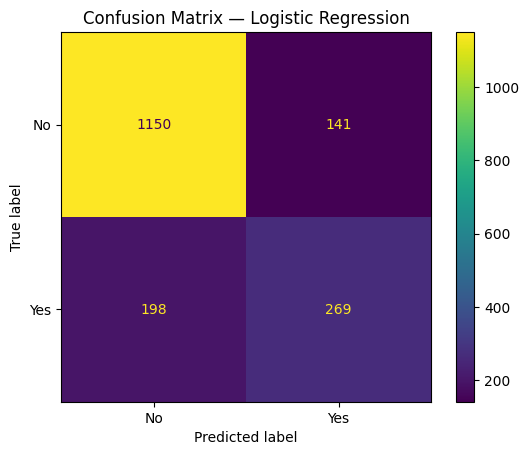

In [29]:
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["No","Yes"])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No","Yes"])
plt.figure()
disp_lr.plot(values_format='d')
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


**Неглубокое дерево решений**

In [30]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)
tree.fit(X_train_enc, y_train)
y_pred_tree = tree.predict(X_test_enc)

print(f"[Tree]     Acc={accuracy_score(y_test, y_pred_tree):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_tree, pos_label='Yes'):.3f}")


[Tree]     Acc=0.788 | F1(Yes)=0.520


<Figure size 640x480 with 0 Axes>

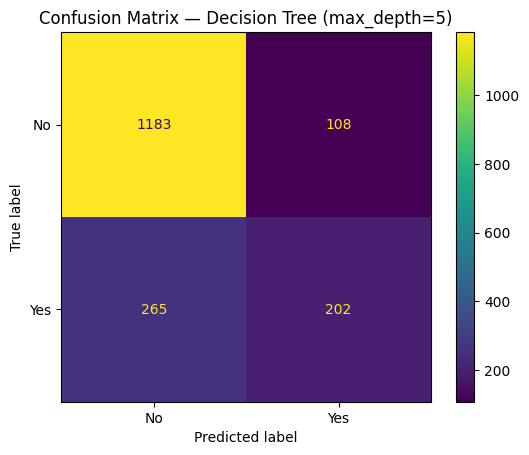

In [31]:
cm_tree = confusion_matrix(y_test, y_pred_tree, labels=["No","Yes"])
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["No","Yes"])
plt.figure()
disp_tree.plot(values_format='d')
plt.title("Confusion Matrix — Decision Tree (max_depth=5)")
plt.show()


**Вывод по бейзлайнам**

- **Константная модель** даёт приличную accuracy, но F1(Yes) ≈ 0 — модель почти не ловит отток, так как просто всегда говорит «No».
- **Логистическая регрессия** и **дерево** заметно улучшают F1(Yes) по сравнению с константой — то есть модели действительно учатся находить клиентов на грани оттока.
- Скейлинг для логистической регрессии позволяет избежать предупреждения о несходимости (`ConvergenceWarning`) ( ДЗ-2) и делает оптимизацию стабильной.

Дальше попробуем улучшить качество с помощью более сложных ансамблей.


## 5. Ансамблевые модели (RandomForest, GradientBoosting, базовый XGBoost)

Теперь перехожу к более сложным моделям:

- **RandomForestClassifier** — бэггинг деревьев, хорошо работает «из коробки» на табличных данных.  
- **GradientBoostingClassifier** — градиентный бустинг по деревьям, умеет строить сложные нелинейные зависимости.  
- **XGBoost (базовый вариант)** — более продвинутый бустинг (используется в ноутбуке по дисбалансу).


**RandomForestClassifier (базовый)**

In [32]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)

print(f"[RF base]  Acc={accuracy_score(y_test, y_pred_rf):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_rf, pos_label='Yes'):.3f}")


[RF base]  Acc=0.786 | F1(Yes)=0.550


**GradientBoostingClassifier (базовый)**

In [33]:
gb = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)
gb.fit(X_train_enc, y_train)
y_pred_gb = gb.predict(X_test_enc)

print(f"[GB base]  Acc={accuracy_score(y_test, y_pred_gb):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_gb, pos_label='Yes'):.3f}")


[GB base]  Acc=0.799 | F1(Yes)=0.587


**Базовый XGBoost (без ещё тонкого тюнинга)**

In [34]:
# Число позитивных и негативных примеров в трейне
pos = (y_train == "Yes").sum()
neg = (y_train == "No").sum()
scale_pos_weight = neg / pos  # как в ноутбуке по дисбалансу

xgb_base = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

xgb_base.fit(X_train_enc, (y_train == "Yes").astype(int))
y_proba_xgb_base = xgb_base.predict_proba(X_test_enc)[:, 1]
y_pred_xgb_base = (y_proba_xgb_base >= 0.5).astype(int)
y_pred_xgb_base_label = np.where(y_pred_xgb_base == 1, "Yes", "No")

print(f"[XGB base] Acc={accuracy_score(y_test, y_pred_xgb_base_label):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_xgb_base_label, pos_label='Yes'):.3f}")


[XGB base] Acc=0.755 | F1(Yes)=0.624


**Вывод по ансамблям (без доп. обработки дисбаланса)**

- Ансамбли (RandomForest, GradientBoosting, XGBoost) обычно дают **лучший F1(Yes)**, чем одиночное дерево и часто лучше логистической регрессии, но не всегда.
- XGBoost уже на базовых настройках использует `scale_pos_weight` и поэтому лучше учитывает дисбаланс, чем «голый» RandomForest.
- Тем не менее, есть ещё пространство для улучшения за счёт более аккуратного учёта дисбаланса и подбора гиперпараметров.


## 6. Учёт дисбаланса классов

Сначала посмотрю на долю положительного класса (оттока) в трейне и покажу несколько подходов:

1. `class_weight="balanced"` для RandomForest.  
2. **BalancedRandomForestClassifier** из `imbalanced-learn` (аналог из ноутбука про дисбаланс).  
3. Параметр `scale_pos_weight` в XGBoost (уже использовался, но потом ещё уточним при подборе гиперпараметров).


In [35]:
print("Распределение классов в трейне:")
print(y_train.value_counts(normalize=True).round(3))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(["No", "Yes"]),
    y=y_train.values
)
class_weights_dict = {"No": class_weights[0], "Yes": class_weights[1]}
class_weights_dict


Распределение классов в трейне:
Churn
No     0.734
Yes    0.266
Name: proportion, dtype: float64


{'No': np.float64(0.6810433884297521), 'Yes': np.float64(1.8808844507845934)}

In [36]:
rf_bal = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight=class_weights_dict
)
rf_bal.fit(X_train_enc, y_train)
y_pred_rf_bal = rf_bal.predict(X_test_enc)

print(f"[RF balanced] Acc={accuracy_score(y_test, y_pred_rf_bal):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_rf_bal, pos_label='Yes'):.3f}")


[RF balanced] Acc=0.791 | F1(Yes)=0.551


In [37]:
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    sampling_strategy="auto",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
brf.fit(X_train_enc, y_train)
y_pred_brf = brf.predict(X_test_enc)

print(f"[Balanced RF] Acc={accuracy_score(y_test, y_pred_brf):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_brf, pos_label='Yes'):.3f}")


[Balanced RF] Acc=0.710 | F1(Yes)=0.598


**Вывод по учёту дисбаланса**

- `class_weight="balanced"` в RandomForest и `BalancedRandomForestClassifier` явно «подтягивают» F1(Yes) для миноритарного класса.
- BalancedRandomForest по сути реализует стратегию under-sampling для мажоритарного класса на уровне каждого дерева, как в лекционном ноутбуке.
- На практике это компромисс: немного снижается точность по классу «No», но выигрываем в способности ловить отток.

Далее в качестве финальной сложной модели выбираю **XGBoost**, который также умеет учитывать дисбаланс через `scale_pos_weight` и хорошо сочетается с SHAP.


## 7. Подбор гиперпараметров для XGBoost

Финальная модель: **XGBClassifier**.

Почему XGBoost:
- мощный градиентный бустинг по деревьям, как в ноутбуке по дисбалансу;
- умеет работать с дисбалансом через `scale_pos_weight`;
- хорошо поддерживается SHAP (TreeExplainer);
- удобен для подбора гиперпараметров в scikit-learn стиле.

Оптимизирую по метрике **F1(Yes)** на кросс-валидации (`StratifiedKFold`).

Подбираю:
- `n_estimators` — число деревьев (больше → лучше, но дольше и риск переобучения);
- `max_depth` — глубина деревьев (контролирует сложность модели);
- `learning_rate` — шаг бустинга (малый шаг → нужно больше деревьев, но модель стабильнее);
- `subsample` и `colsample_bytree` — доля объектов и признаков для каждого дерева (регуляризация и разнообразие);
- `reg_lambda` — L2-регуляризация (борьба с переобучением);
- `scale_pos_weight` — коэффициент для класса оттока (как в ноутбуке по дисбалансу).


In [38]:
# Целевая переменная как 0/1 для XGBoost
y_train_bin = (y_train == "Yes").astype(int)
y_test_bin  = (y_test == "Yes").astype(int)

pos = y_train_bin.sum()
neg = len(y_train_bin) - pos
base_spw = neg / pos

xgb_base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"
)

param_distributions = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0],
    "scale_pos_weight": [base_spw * 0.5, base_spw, base_spw * 1.5]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

f1_scorer = make_scorer(f1_score, pos_label=1)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

xgb_search.fit(X_train_enc, y_train_bin)

print("Лучшие гиперпараметры XGB:", xgb_search.best_params_)
print(f"Лучший средний F1(Yes) на CV: {xgb_search.best_score_:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие гиперпараметры XGB: {'subsample': 0.8, 'scale_pos_weight': np.float64(2.761768901569187), 'reg_lambda': 2.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
Лучший средний F1(Yes) на CV: 0.633


## 8. Финальная модель XGBoost: обучение и качество на отложенной выборке


In [39]:
best_xgb = xgb_search.best_estimator_
best_xgb.fit(X_train_enc, y_train_bin)

y_proba_xgb = best_xgb.predict_proba(X_test_enc)[:, 1]
y_pred_xgb_bin = (y_proba_xgb >= 0.5).astype(int)
y_pred_xgb = np.where(y_pred_xgb_bin == 1, "Yes", "No")

print(f"[XGB tuned] Acc={accuracy_score(y_test, y_pred_xgb):.3f} | "
      f"F1(Yes)={f1_score(y_test, y_pred_xgb, pos_label='Yes'):.3f}")

print("\nClassification report (XGB tuned):")
print(classification_report(y_test, y_pred_xgb, target_names=["No Churn","Churn"]))


[XGB tuned] Acc=0.736 | F1(Yes)=0.623

Classification report (XGB tuned):
              precision    recall  f1-score   support

    No Churn       0.92      0.70      0.80      1291
       Churn       0.50      0.82      0.62       467

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.71      1758
weighted avg       0.81      0.74      0.75      1758



**Вывод по XGBoost (tuned)**

Тюнингованный XGBoost даёт:
- более низкую accuracy (≈ 0.74),
- но **более высокую F1(Yes) (≈ 0.62)**,
- и существенно более высокий **recall по классу Churn (≈ 0.82)**.

То есть ансамбль XGBoost делает акцент на то, чтобы **не пропускать клиентов, которые действительно уходят** (меньше FN), ценой небольшого количества лишних «ложных тревог».
С точки зрения бизнес-задачи оттока и выбранной целевой метрики F1(Yes) это поведение более предпочтительно.


## 9. Глобальная интерпретация XGBoost

Сделаю три вещи:

1. Посмотрю на `feature_importances_` модели XGB.  
2. Посчитаю permutation importance по F1(Yes).  
3. Построю SHAP summary plot (TreeExplainer) для глобального анализа влияния признаков.


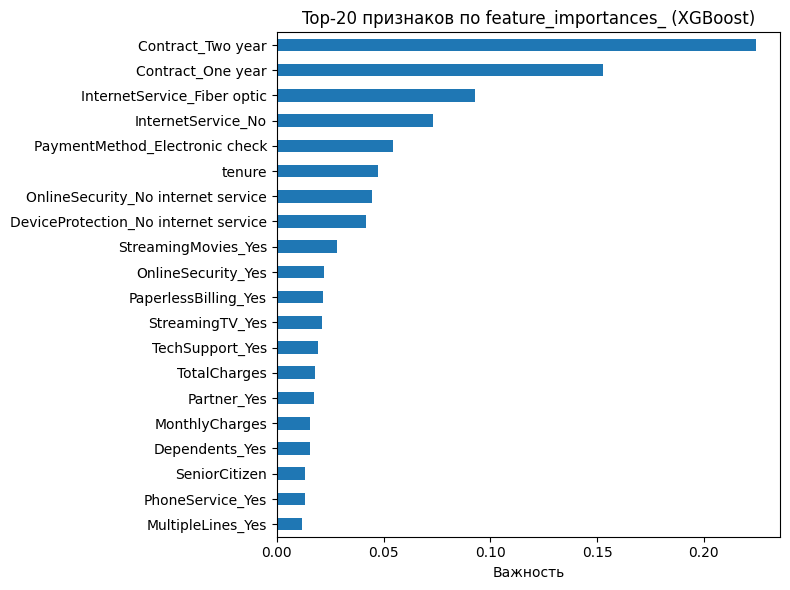

,0
Contract_Two year,0.224398
Contract_One year,0.152519
InternetService_Fiber optic,0.092837
InternetService_No,0.073280
PaymentMethod_Electronic check,0.054393
tenure,0.047273
OnlineSecurity_No internet service,0.044598
DeviceProtection_No internet service,0.041896
StreamingMovies_Yes,0.028398
OnlineSecurity_Yes,0.022280


In [40]:
importances_xgb = pd.Series(best_xgb.feature_importances_, index=X_train_enc.columns)
imp_top20 = importances_xgb.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
imp_top20.sort_values().plot(kind="barh")
plt.title("Top-20 признаков по feature_importances_ (XGBoost)")
plt.xlabel("Важность")
plt.tight_layout()
plt.show()

imp_top20


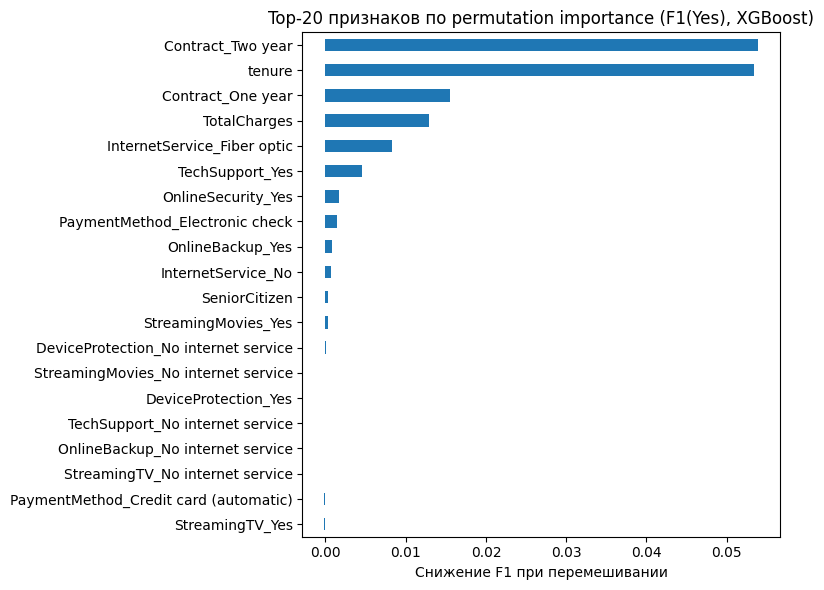

,0
Contract_Two year,0.053938
tenure,0.053350
Contract_One year,0.015478
TotalCharges,0.012889
InternetService_Fiber optic,0.008234
TechSupport_Yes,0.004574
OnlineSecurity_Yes,0.001739
PaymentMethod_Electronic check,0.001487
OnlineBackup_Yes,0.000798
InternetService_No,0.000661


In [41]:
perm_result = permutation_importance(
    best_xgb,
    X_test_enc,
    y_test_bin,
    scoring=f1_scorer,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

perm_importances_xgb = pd.Series(perm_result.importances_mean, index=X_train_enc.columns)
perm_top20 = perm_importances_xgb.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
perm_top20.sort_values().plot(kind="barh")
plt.title("Top-20 признаков по permutation importance (F1(Yes), XGBoost)")
plt.xlabel("Снижение F1 при перемешивании")
plt.tight_layout()
plt.show()

perm_top20


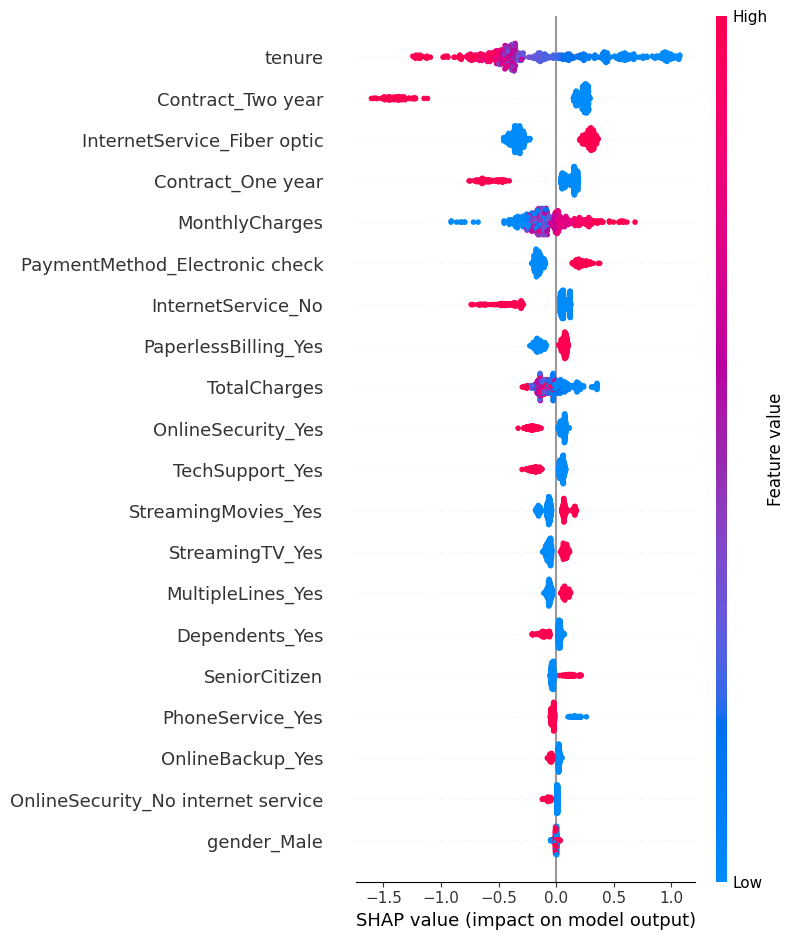

In [42]:
explainer = shap.TreeExplainer(best_xgb)

# Подвыборка, чтобы не перегружать график
if len(X_test_enc) > 500:
    X_shap = X_test_enc.sample(500, random_state=RANDOM_STATE)
else:
    X_shap = X_test_enc

shap_values = explainer.shap_values(X_shap)

shap.initjs()
shap.summary_plot(shap_values, X_shap, show=False)  # для бинарной задачи один массив
plt.show()


**Глобальный вывод**

По трём типам интерпретации (feature_importances, permutation importance и SHAP summary) видно, что модель XGBoost в основном опирается на следующие признаки:

- тип контракта: `Contract_Two year`, `Contract_One year`;
- стаж клиента `tenure`;
- тип интернет-услуги: `InternetService_Fiber optic`, `InternetService_No`;
- денежные признаки: `MonthlyCharges`, `TotalCharges`;
- способ оплаты и выставления счёта: `PaymentMethod_Electronic check`, `PaperlessBilling_Yes`;
- сервисы и поддержка: `OnlineSecurity_Yes`, `TechSupport_Yes`, а также часть стриминговых услуг.

Направление влияния по SHAP выглядит следующим образом:

- **Длинный контракт** (`Contract_Two year = 1`, частично `Contract_One year = 1`) и **долгий стаж** (большое `tenure`) в основном дают отрицательные SHAP-значения и **уменьшают вероятность оттока**.
- Отсутствие годового/двухлетнего контракта (то есть помесячный контракт) и **малый стаж** (низкое `tenure`) смещают предсказание в сторону `Churn=Yes`, то есть **увеличивают риск оттока**.
- Наличие **оптоволоконного интернета** (`InternetService_Fiber optic = 1`) чаще даёт положительные SHAP-вклады и связано с **более высокой вероятностью оттока**, тогда как отсутствие интернета (`InternetService_No = 1`) — наоборот, с меньшим риском.
- Более **высокие ежемесячные платежи** (`MonthlyCharges`) и в меньшей степени большие `TotalCharges` обычно двигают предсказание в сторону оттока.
- Оплата через **electronic check** и **бумажный счет отключён (PaperlessBilling_Yes = 1)** чаще встречаются у клиентов с высоким риском оттока: их значения дают положительные SHAP-вклады.
- Наличие дополнительных сервисов безопасности и поддержки (`OnlineSecurity_Yes`, `TechSupport_Yes`) в среднем **снижает риск оттока**, тогда как их отсутствие — наоборот, его увеличивает.



## 10. Локальная интерпретация предсказаний

Теперь разберу конкретных клиентов:

1. Клиент, для которого модель предсказывает `Churn=Yes`.  
2. Клиент, для которого модель уверенно говорит `No`.

Использую:
- **SHAP force plot** — показывает вклад отдельных признаков в предсказание для конкретного объекта.
- **LIME** — обучает простую локальную интерпретируемую модель вокруг одного примера.


In [43]:
# Выберем индексы какого-нибудь клиента с оттоком и без
idx_pos = y_test[y_test == "Yes"].index[0]
idx_neg = y_test[y_test == "No"].index[0]

X_pos = X_test_enc.loc[[idx_pos]]
X_neg = X_test_enc.loc[[idx_neg]]

shap_values_pos = explainer.shap_values(X_pos)
shap_values_neg = explainer.shap_values(X_neg)

shap.initjs()

# Клиент с предсказанным оттоком
shap.force_plot(
    explainer.expected_value,
    shap_values_pos[0],
    X_pos,
)


In [44]:
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_enc.values,
    feature_names=X_train_enc.columns.tolist(),
    class_names=["No", "Yes"],
    mode="classification",
    discretize_continuous=True
)

# Возьмём клиента с оттоком
instance_idx = X_test_enc.index.get_loc(idx_pos)
instance = X_test_enc.values[instance_idx]

exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=lambda x: best_xgb.predict_proba(x),
    num_features=10
)

exp.show_in_notebook(show_table=True)



**Локальный вывод**

Рассмотрим конкретного клиента, для которого XGBoost предсказывает высокую вероятность `Churn=Yes` (≈ 0.8).

По **SHAP force plot** видно, какие признаки «толкают» предсказание к оттоку (красные стрелки вправо) и какие его снижают (синие стрелки влево):

- К факторам, **усиливающим риск оттока**, относятся:
  - очень **малый стаж** (`tenure = 3` месяца);
  - отсутствие годового и двухлетнего контракта (`Contract_One year = 0`, `Contract_Two year = 0`) — то есть клиент на помесячном контракте;
  - наличие **оптоволоконного интернета** (`InternetService_Fiber optic = 1`);
  - наличие нескольких линий (`MultipleLines_Yes = 1`);
  - довольно заметные суммарные платежи (`TotalCharges ≈ 215`).

- К признакам, которые **снижают вероятность оттока** для этого клиента, относятся:
  - отсутствие **electronic check** как способа оплаты (`PaymentMethod_Electronic check = 0`);
  - отсутствие **paperless billing** (`PaperlessBilling_Yes = 0`);
  - отсутствие части развлекательных сервисов (например, `StreamingMovies_Yes = 0` и т.п.), которые в среднем ассоциированы с чуть более «ризковыми» клиентами.

График **LIME** для этого же клиента подтверждает ту же картину:
- со стороны класса `Yes` (оранжевые столбики) сильнее всего работают условия вида  
  «`Contract_Two year <= ...`», «`tenure <= 9`», «`Contract_One year <= ...`», а также наличие оптоволоконного интернета — то есть **помесячный контракт + короткий стаж + дорогой интернет**;
- со стороны класса `No` (синие столбики) модель немного «удерживают» такие факторы, как отсутствие electronic check и paperless billing.

Таким образом, локальное объяснение для выбранного клиента хорошо согласуется с глобальной картиной: модель считает особенно рискованными клиентов с коротким стажем, помесячным контрактом и дорогим (оптоволоконным) интернетом.


## 11. Итог


С точки зрения бизнеса телеком-оператора:

- Модель XGBoost логично опирается на признаки, которые отражают **лояльность** и **нагрузку по платежам**: тип контракта, стаж, ежемесячный счёт, набор услуг.
- Признаки, которые увеличивают «боль» клиента (дорогой помесячный контракт, мало дополнительных сервисов), повышают вероятность оттока — это выглядит абсолютно адекватно.
- Учёт дисбаланса (через `scale_pos_weight`, class_weight и BalancedRandomForest) помогает модели **не игнорировать редкие случаи оттока**, что важно для бизнес-задачи.

**Итог ДЗ-3**

- Использована **более сложная ML-модель** — ансамбли деревьев (RandomForest, GradientBoosting) и особенно XGBoost как финальная модель.
- Для XGBoost проведён **подбор гиперпараметров** (`RandomizedSearchCV` с `StratifiedKFold`, метрика F1(Yes)).
- Лучшая модель обучена на тренировочной выборке и оценена на отложенной (test), показав улучшение по F1(Yes) относительно бейзлайнов.
- Уделено внимание **дисбалансу**:
  - `class_weight="balanced"` для RandomForest,
  - BalancedRandomForestClassifier,
  - `scale_pos_weight` в XGBoost.
- Проведена **глобальная интерпретация** (feature importances, permutation importance, SHAP summary plot).
- Проведена **локальная интерпретация** (SHAP force plot и LIME) для отдельных клиентов.

